# Metrics

## Install dependencies

In [ ]:
!pip install datasets spacy plotly -qqq

## Load dataset and spaCy model

In [ ]:
import rubrix as rb
import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm")
dataset = load_dataset("wnut_17", split="train")

## Log records into a Rubrix dataset

In [ ]:
from tqdm.auto import tqdm

records = []

for record in tqdm(dataset, total=len(dataset)):
    # We only need the text of each instance
    text = " ".join(record["tokens"])

    # spaCy Doc creation
    doc = nlp(text)

    # Entity annotations
    entities = [
        (ent.label_, ent.start_char, ent.end_char)
        for ent in doc.ents
    ]

    # Pre-tokenized input text
    tokens = [token.text  for token in doc]

    # Rubrix TokenClassificationRecord list
    records.append(
        rb.TokenClassificationRecord(
            text=text,
            tokens=tokens,
            prediction=entities,
            prediction_agent="en_core_web_sm",
        )
    )
rb.log(records, name="spacy_sm_wnut17")

## Explore the metrics for the dataset

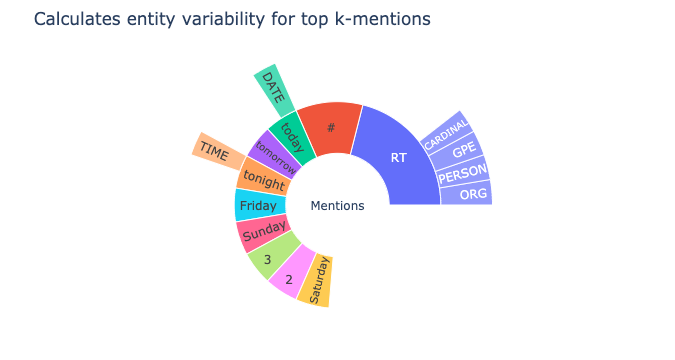

In [42]:
from rubrix.metrics.token_classification import mention_consistency

mention_consistency(name="spacy_sm_wnut17").visualize()

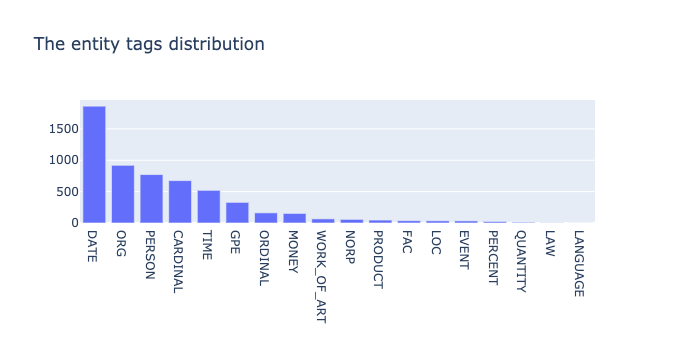

In [43]:
from rubrix.metrics.token_classification import entity_tags

entity_tags(name="spacy_sm_wnut17").visualize()

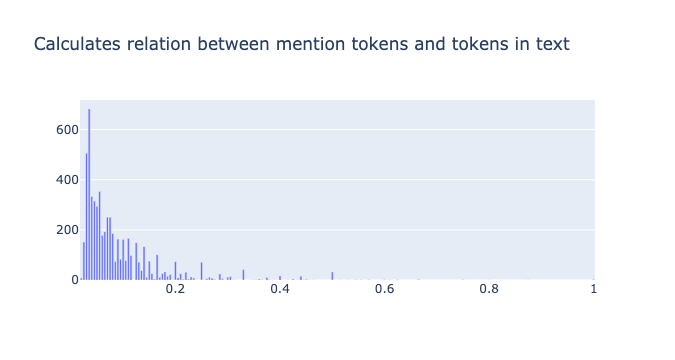

In [39]:
from rubrix.metrics.token_classification import entity_density

entity_density(name="spacy_sm_wnut17").visualize()

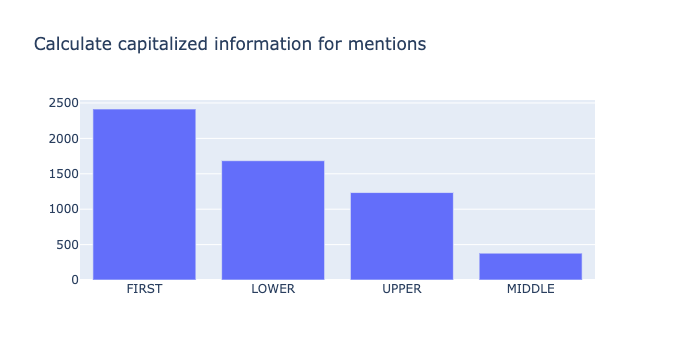

In [40]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="spacy_sm_wnut17").visualize()

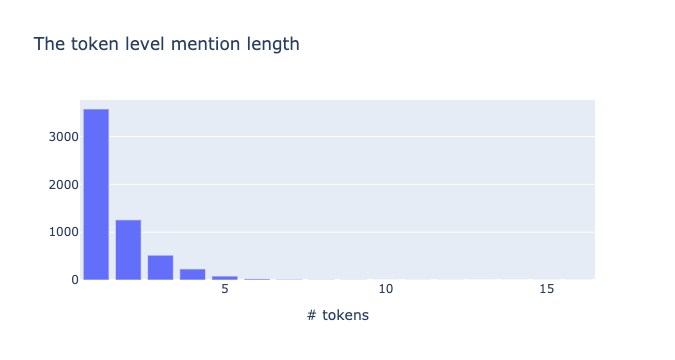

In [41]:
from rubrix.metrics.token_classification import mention_length
mention_length(name="spacy_sm_wnut17").visualize()